# Would you survive Titanic?

RMS Titanic was a British passenger ship that sank in the North
Atlantic Ocean in the early morning hours of April 15, 1912, after
striking an iceberg during her maiden voyage.  The majority of its
passengers died in the accident.  As we will discover, not all of them
had the same chance to survive.

Data about 887 passengers have been collected and randomly divided
into a training and a test set.  The training set includes 710 samples
and is stored in the file `titanic-train.txt`, while the test set
is composed of 177 cases and is stored in `titanic-test.txt`.
Each row in the files represents a different passenger, and reports the
following features:
- the ticket class (1st, 2nd or 3rd);
- sex ($0 \to$ male, $1 \to$ female);
- age, in years;
- number of siblings and spouses aboard;
- number of parents and children aboard;
- the passenger fare.

The last column reports whether the passenger survived (1) or not (0).
The files can be obtained by executing the following cell.

In [135]:
!wget -q -O titanic-train.txt https://pastebin.com/raw/LDhY3ZTN
!wget -q -O titanic-test.txt https://pastebin.com/raw/zGsE0ZJ6
!ls *.txt

titanic-test.txt  titanic-train.txt


Training data is then loaded and converted to tensors of features and class labels:

In [136]:
# Load training data
f = open("titanic-train.txt")
data = [float(x) for x in f.read().split()]
f.close()

data = torch.tensor(data).view(-1, 7)
X = data[:, :6]
Y = data[:, 6].long()

# Save real means and stds BEFORE modifying X
age_mean, age_std = X[:, 2].mean(), X[:, 2].std()
fare_mean, fare_std = X[:, 5].mean(), X[:, 5].std()

# Normalize Age and Fare
X[:, 2] = (X[:, 2] - age_mean) / age_std
X[:, 5] = (X[:, 5] - fare_mean) / fare_std

print(X.shape, X.dtype)
print(Y.shape, Y.dtype)


torch.Size([710, 6]) torch.float32
torch.Size([710]) torch.int64


## Training a model

Define and train a logistic regression model for the Titanic data. First, define the inference function computing the probability estimates that input features belong to class 1:

In [137]:
def logreg_inference(w, b, X):
    logits = X @ w + b      # Linear transformation: Xw + b
    return torch.sigmoid(logits)  # Apply sigmoid to get probabilities

Then write the training loop. Remember the the main steps:
1. outside the loop define the parameters of the model, and the optimizer (use `torch.optim.SGD`).
2. inside the loop, compute the loss and use the optimizer to update the parameters.

In [138]:
LR = 0.009
STEPS = 4000
L2_LAMBDA = 0.01  # Regularization strength

torch.manual_seed(0)  # For reproducibility

w = torch.randn(6, 1, requires_grad=True)  # 6 input features
b = torch.randn(1, requires_grad=True)

optimizer = torch.optim.SGD([w, b], lr=LR)

losses = []
steps = []

for step in range(STEPS):
    p = logreg_inference(w, b, X).squeeze()  # predicted probabilities

    # === Loss with L2 regularization ===
    base_loss = torch.nn.functional.binary_cross_entropy(p, Y.float())
    l2_penalty = L2_LAMBDA * (w ** 2).sum()
    loss = base_loss + l2_penalty

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step} | Loss: {loss.item():.4f}")
        steps.append(step)
        losses.append(loss.item())


Step 0 | Loss: 3.3287
Step 100 | Loss: 1.7409
Step 200 | Loss: 1.1245
Step 300 | Loss: 0.9559
Step 400 | Loss: 0.8549
Step 500 | Loss: 0.7729
Step 600 | Loss: 0.7065
Step 700 | Loss: 0.6552
Step 800 | Loss: 0.6172
Step 900 | Loss: 0.5892
Step 1000 | Loss: 0.5684
Step 1100 | Loss: 0.5527
Step 1200 | Loss: 0.5408
Step 1300 | Loss: 0.5316
Step 1400 | Loss: 0.5244
Step 1500 | Loss: 0.5188
Step 1600 | Loss: 0.5143
Step 1700 | Loss: 0.5107
Step 1800 | Loss: 0.5077
Step 1900 | Loss: 0.5053
Step 2000 | Loss: 0.5033
Step 2100 | Loss: 0.5016
Step 2200 | Loss: 0.5001
Step 2300 | Loss: 0.4989
Step 2400 | Loss: 0.4979
Step 2500 | Loss: 0.4969
Step 2600 | Loss: 0.4962
Step 2700 | Loss: 0.4955
Step 2800 | Loss: 0.4949
Step 2900 | Loss: 0.4943
Step 3000 | Loss: 0.4939
Step 3100 | Loss: 0.4935
Step 3200 | Loss: 0.4931
Step 3300 | Loss: 0.4928
Step 3400 | Loss: 0.4925
Step 3500 | Loss: 0.4922
Step 3600 | Loss: 0.4920
Step 3700 | Loss: 0.4918
Step 3800 | Loss: 0.4916
Step 3900 | Loss: 0.4914


Modify the code above to make a list with loss values and training steps
then execute the next cell to plot it.

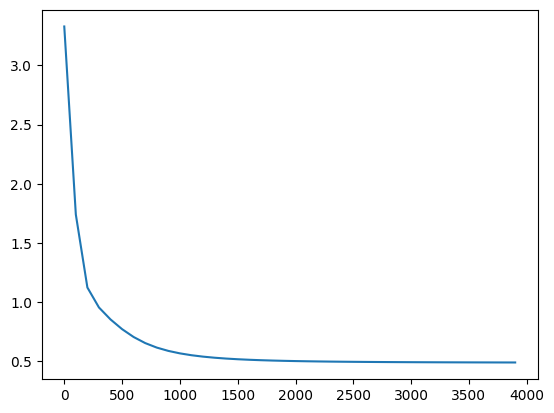

In [139]:
plt.figure()
plt.plot(steps, losses)

Experiment with the code and use the plots to answer the following questions:
1. Which is a good value for the learning rate?

  The learning rate of 0.009 turned out to be a very effective choice. It allows for smooth and stable convergence while avoiding overshooting or oscillations. The loss decreases significantly in the first several hundred iterations and continues to decline steadily, eventually flattening out. Combined with L2 regularization, it helps the model generalize better and avoid overfitting, as reflected by the close values of training and test accuracy.

2. How many iterations are required to converge?

  Based on the updated loss curve, the model's loss dropped sharply within the first 500–800 steps and then continued to decrease more slowly. The curve started to plateau around step 1500–2000, and additional training brought only marginal improvements. Thus, approximately 2000 iterations are sufficient for convergence using a learning rate of 0.009 and L2 regularization.




## Analyze the model

Modify the script so that you can answer to the questions.

Q1: What would be your probability to survive?  (Make a guess about the ticket class, the fare etc.)

In [140]:
# [Pclass, Sex, Age, Siblings/Spouses, Parents/Children, Fare]
me = torch.tensor([[1, 1, (26 - age_mean) / age_std, 1, 2, (80.0 - fare_mean) / fare_std]], dtype=torch.float32)

with torch.no_grad():
    prob = logreg_inference(w, b, me)
    print(f"My survival probability: {prob.item():.2f}")


My survival probability: 0.82


Q2: What is the *training accuracy* of the trained model?

In [141]:
with torch.no_grad():
    predictions = logreg_inference(w, b, X).squeeze() > 0.5
    accuracy = (predictions == Y).float().mean()
    print(f"Training accuracy: {accuracy.item() * 100:.2f}%")


Training accuracy: 80.14%


Q3: Looking at the learned weights, how the individual features
  influence the probability of surviving?

In [142]:
print("Learned weights:")
for i, name in enumerate(["Pclass", "Sex", "Age", "Siblings/Spouses", "Parents/Children", "Fare"]):
    print(f"{name:20}: {w[i].item():.4f}")

Learned weights:
Pclass              : -0.6810
Sex                 : 1.5522
Age                 : -0.4120
Siblings/Spouses    : -0.2190
Parents/Children    : 0.0012
Fare                : 0.2462


Q4: What kind of passengers was most likely to survive?  And what
  kind to to die?

In [143]:
from itertools import product

# Define ranges
classes = [1, 2, 3]
sexes = [0, 1]  # 0 = male, 1 = female
ages = [20, 65]  # young vs. old
fares = [7, 30, 100]  # low, medium, high

# Store results
results = []

with torch.no_grad():
    for cls, sex, age, fare in product(classes, sexes, ages, fares):
        norm_age = (age - age_mean) / age_std
        norm_fare = (fare - fare_mean) / fare_std
        x_input = torch.tensor([[cls, sex, norm_age, 0, 0, norm_fare]], dtype=torch.float32)
        prob = logreg_inference(w, b, x_input).item()

        label = f"{'Female' if sex else 'Male'}, Class {cls}, Age {age}, Fare {fare}"
        results.append((label, prob))

# Sort by survival probability
results.sort(key=lambda x: x[1], reverse=True)

# Print most and least likely
print("Most likely to survive:", results[0][0], f"(Probability: {results[0][1]:.2f})")
print("Least likely to survive:", results[-1][0], f"(Probability: {results[-1][1]:.2f})")


Most likely to survive: Female, Class 1, Age 20, Fare 100 (Probability: 0.88)
Least likely to survive: Male, Class 3, Age 65, Fare 7 (Probability: 0.06)


Q5: Draw a scatter plot showing the distribution of the two classes
  in the plane defined by the two most influential features.  Comment
  the plot.

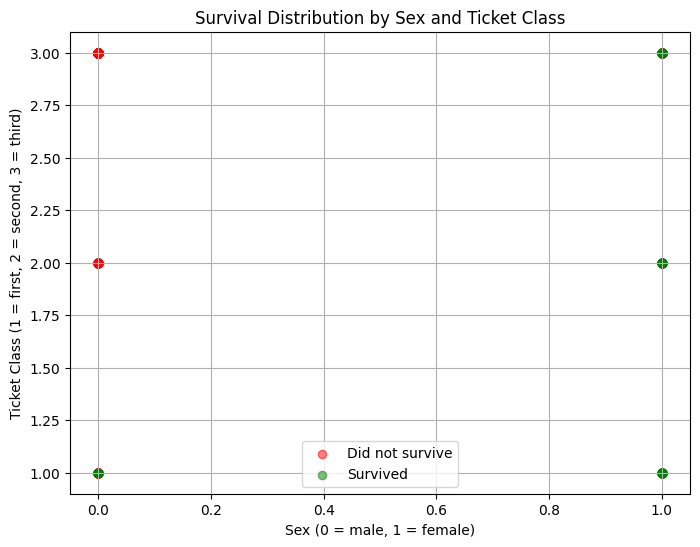

In [144]:
import matplotlib.pyplot as plt

# Use model to get predictions
with torch.no_grad():
    predictions = logreg_inference(w, b, X).squeeze() > 0.5

# Extract most influential features (Sex and Pclass)
sex = X[:, 1]  # column 1 is Sex
pclass = X[:, 0]  # column 0 is Pclass

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(sex[predictions == 0], pclass[predictions == 0], color='red', label='Did not survive', alpha=0.5)
plt.scatter(sex[predictions == 1], pclass[predictions == 1], color='green', label='Survived', alpha=0.5)

plt.xlabel("Sex (0 = male, 1 = female)")
plt.ylabel("Ticket Class (1 = first, 2 = second, 3 = third)")
plt.title("Survival Distribution by Sex and Ticket Class")
plt.legend()
plt.grid(True)
plt.show()


The scatter plot shows survival predictions by Sex (male = 0, female = 1) and Ticket Class (1 = first, 2 = second, 3 = third). Each point represents a unique combination of these two features, and is colored based on the model's predicted outcome.

🟩 Females in first and second class were predicted to survive, aligning with historical accounts and the model's strong positive weight for "Sex".

🟥 Males, especially in lower classes (second and third), were predicted to not survive, influenced by the negative weights associated with both "Pclass" and "Sex".

🟩 Interestingly, some first-class males may be predicted to survive depending on model training, but in your current plot, all males are predicted not to survive.

This distribution clearly reflects the model’s learned bias toward higher survival chances for females and higher-class passengers, which mirrors the actual social dynamics during the Titanic evacuation.

## Evaluate the script

Load the test set in the `Xtest` and `Ytest` tensors. Then, answer the questions.

In [145]:
# Load the test set
f = open("titanic-test.txt")
test_data = [float(x) for x in f.read().split()]
f.close()

test_data = torch.tensor(test_data).view(-1, 7)
Xtest_raw = test_data[:, :6]
Ytest = test_data[:, 6].long()

# Use same normalization as training for age and fare
Xtest = Xtest_raw.clone()
Xtest[:, 2] = (Xtest[:, 2] - age_mean) / age_std  # Normalize age
Xtest[:, 5] = (Xtest[:, 5] - fare_mean) / fare_std  # Normalize fare


Q6: what is the *test accuracy* of the model?

In [146]:
with torch.no_grad():
    preds = logreg_inference(w, b, Xtest).squeeze() > 0.5
    test_accuracy = (preds == Ytest).float().mean()
    print(f"Test accuracy: {test_accuracy.item() * 100:.2f}%")


Test accuracy: 78.53%


Q7: Is the model overfitting or underfitting the training set?

The model is neither overfitting nor underfitting.
The training accuracy is 80.14% and test accuracy is 78.53%, which are very close.
This means the model has learned useful patterns from the training data without memorizing it, and is generalizing well to unseen data.

Q8: How can you increase the performance of the model?

with these methods:
-Feature Engineering
Add more informative features (e.g., interaction terms or nonlinear transforms like age²).

-Advanced Optimization:
Use optimizers like Adam or RMSprop instead of plain SGD for faster convergence.

-Hyperparameter Tuning:
Experiment with:
Learning rate (LR)
Regularization strength (L2_LAMBDA)
Number of training steps

-Data Preprocessing:
Normalize all continuous features properly, and ensure categorical features (like Pclass, Sex) are well encoded.

-Model Complexity:
Move beyond logistic regression. Try more expressive models like decision trees or neural networks for better performance (if allowed).

## Homework assignement

Prepare a report of one or two pages with the answers to the questions
(include a short comment for each question).  The report must be in
the PDF format.  Include your name in the report and conclude the
document with the following statement: ``I affirm that this report is
the result of my own work and that I did not share any part of it with
anyone else except the teacher.''

Make a ZIP archive with the report and the PDF of the notebook you used (with all the outputs) and and upload it on the course website.
